In [33]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


#!/usr/bin/env python

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import bilby

outdir = 'outdir'
label = 'LISAstatic_roq_PE'


In [34]:
scale_factor = 1.0

# Load in the pieces for the linear part of the ROQ. Note you will need to
# adjust the filenames here to the correct paths on your machine
basis_matrix_linear = np.load("B_linear.npy").T
freq_nodes_linear = np.load("fnodes_linear.npy") * scale_factor

# Load in the pieces for the quadratic part of the ROQ
basis_matrix_quadratic = np.load("B_quadratic.npy").T
freq_nodes_quadratic = np.load("fnodes_quadratic.npy") * scale_factor

# Load the parameters describing the valid parameters for the basis.
# params = np.genfromtxt("/Users/hxc/Downloads/ROQ_data-master/IMRPhenomPv2/4s/params.dat", names=True)
params = np.genfromtxt("params.dat", names=True)
params['flow'] *= scale_factor
params['fhigh'] *= scale_factor
params['seglen'] /= scale_factor
params['chirpmassmin'] /= scale_factor
params['chirpmassmax'] /= scale_factor
params['compmin'] /= scale_factor



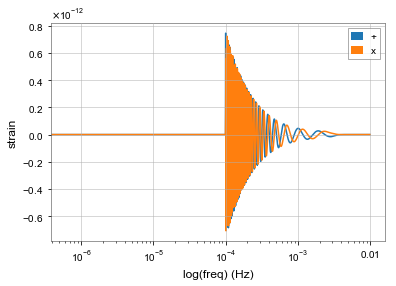

In [35]:
# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170232)

duration = 1638400 / scale_factor   # deltaF = 1.0e-6
sampling_frequency = 2.0e-2 * scale_factor  # fmax = 1.0e-2

injection_parameters = dict(
    mass_1=3.6e6, mass_2=2.9e6, a_1=0.4, a_2=0.3, tilt_1=0.0, tilt_2=0.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=1000, theta_jn=0.4, psi=0.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=1.0e-4,
                          minimum_frequency=1.0e-4)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    start_time=injection_parameters['geocent_time'] - duration)


freq = waveform_generator.frequency_array
hplus = waveform_generator.frequency_domain_strain(injection_parameters)['plus']
hcross = waveform_generator.frequency_domain_strain(injection_parameters)['cross']
plt.plot(freq, hplus,label='+')
plt.plot(freq, hcross,label='x')
plt.xlabel('log(freq) (Hz)')
plt.ylabel('strain')
plt.legend()
plt.xscale('log')
plt.savefig('LISA_IMRPhenomPv2_waveform.png', dpi=200)

In [36]:
# The location of this new detector is not defined in Bilby, so we need to add it
LISA_static = bilby.gw.detector.Interferometer(
    power_spectral_density=bilby.gw.detector.PowerSpectralDensity(
        psd_file='lisa_psd.txt'),
    name='LISA_static', length=2.5e6,
    minimum_frequency=min(waveform_generator.frequency_array), \
    maximum_frequency=max(waveform_generator.frequency_array),
    latitude=-31.34, longitude=115.91,
    elevation=0., xarm_azimuth=2., yarm_azimuth=125.)

# Set up new detector to InterferomerList
interferometers = bilby.gw.detector.InterferometerList([])

# append the new detector to the list 
interferometer = interferometers.append(LISA_static)


for interferometer in interferometers:
    interferometer.set_strain_data_from_zero_noise(
        sampling_frequency=sampling_frequency, duration=duration,
     start_time=injection_parameters['geocent_time'] - duration)
    interferometer.inject_signal(
        parameters=injection_parameters, waveform_generator=waveform_generator)


11:35 bilby INFO    : Injected signal in LISA_static:
11:35 bilby INFO    :   optimal SNR = 39195.52
11:35 bilby INFO    :   matched filter SNR = 39195.52+0.00j
11:35 bilby INFO    :   mass_1 = 3600000.0
11:35 bilby INFO    :   mass_2 = 2900000.0
11:35 bilby INFO    :   a_1 = 0.4
11:35 bilby INFO    :   a_2 = 0.3
11:35 bilby INFO    :   tilt_1 = 0.0
11:35 bilby INFO    :   tilt_2 = 0.0
11:35 bilby INFO    :   phi_12 = 1.7
11:35 bilby INFO    :   phi_jl = 0.3
11:35 bilby INFO    :   luminosity_distance = 1000
11:35 bilby INFO    :   theta_jn = 0.4
11:35 bilby INFO    :   psi = 0.659
11:35 bilby INFO    :   phase = 1.3
11:35 bilby INFO    :   geocent_time = 1126259642.413
11:35 bilby INFO    :   ra = 1.375
11:35 bilby INFO    :   dec = -1.2108


In [37]:
# make ROQ waveform generator
search_waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    start_time=injection_parameters['geocent_time'] - duration,
    frequency_domain_source_model=bilby.gw.source.binary_black_hole_roq,
    waveform_arguments=dict(
        frequency_nodes_linear=freq_nodes_linear,
        frequency_nodes_quadratic=freq_nodes_quadratic,
        reference_frequency=1.0e-4 * scale_factor, waveform_approximant='IMRPhenomPv2'),
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters)


In [38]:
# create the priors
priors = dict()
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'theta_jn', 'phase', 'psi', 'ra',
            'dec', 'phi_12', 'phi_jl', 'luminosity_distance']:
    priors[key] = injection_parameters[key]
    
priors['mass_1'] = bilby.core.prior.Uniform(2.0e6, 5.0e6, name='mass_1')
priors['mass_2'] = bilby.core.prior.Uniform(2.0e6, 5.0e6, name='mass_2')
priors['geocent_time'] = bilby.core.prior.Uniform(
    injection_parameters['geocent_time'] - 5.0,
    injection_parameters['geocent_time'] + 5.0, latex_label='$t_c$', unit='s')


In [42]:
likelihood = bilby.gw.likelihood.ROQGravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=search_waveform_generator,
    linear_matrix=basis_matrix_linear, quadratic_matrix=basis_matrix_quadratic,
    priors=priors, roq_params=params)

# write the weights to file so they can be loaded multiple times
likelihood.save_weights('weights.npz')

# remove the basis matrices as these are big for longer bases
del basis_matrix_linear, basis_matrix_quadratic

# load the weights from the file
likelihood = bilby.gw.likelihood.ROQGravitationalWaveTransient(
    interferometers=interfermeters, waveform_generator=search_waveform_generator,
    weights='weights.npz', priors=priors)

result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=500,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

# Make a corner plot.
result.plot_corner()



11:56 bilby INFO    : ROQ time-step = nan


ValueError: arange: cannot compute length